# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install bs4 
from bs4 import BeautifulSoup
!pip install lxml
import requests
from datetime import datetime
import seaborn as sb
from functools import reduce
from time import sleep
import ast
import urllib
from selenium import webdriver
import pandas as pd


C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\numpy\core\__init__.py:27: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


# Gathering Data

Scrape current baseball statistics from baseball-reference.com

In [2]:
teams = ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KCR', 
         'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA',
         'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN']

streak_mapping = {'+': 1, '++': 2, '+++': 3, '++++': 4, '+++++': 5, '++++++':6, '+++++++': 7, '++++++++': 8, '+++++++++': 9, '++++++++++': 10, '+++++++++++': 11, '++++++++++++': 12, '+++++++++++++':13, '++++++++++++++':14, '+++++++++++++++': 15,
                  '-': -1, '--': -2, '---': -3, '----': -4, '-----': -5, '------':-6, '-------': -7, '--------': -8, '---------': -9, '----------': -10, '-----------': -11, '------------': -12, '-------------':-13, '--------------':-14, '---------------': -15}

teamsData = {}

for index, team in enumerate(teams):
    ## Collect schedule information for each team
    baseball_schedule_url = 'https://www.baseball-reference.com/teams/' + team + '/2021-schedule-scores.shtml'
    dfs = pd.read_html(baseball_schedule_url)
    scheduleDF = pd.concat(dfs)
    scheduleDF.drop(['Unnamed: 2', 'Unnamed: 4', 'W-L', 'D/N', 'Orig. Scheduled'], axis = 1, inplace = True)
    scheduleDF = scheduleDF[scheduleDF.Opp != 'Opp'] # delete rows where the column statistics are repeated on the website
    scheduleDF.to_csv('1.csv')
    
    ## Collect batting data for each game every team has played
    baseball_batting_data_url = 'https://www.baseball-reference.com/teams/tgl.cgi?team=' + team + '&t=b&year=2021'
    dfs = pd.read_html(baseball_batting_data_url)
    battingDF = pd.concat(dfs)
    battingDF.drop(['Opp', 'R', 'Date', 'Rk', 'Unnamed: 3', 'Gtm', 'Rslt'], axis = 1, inplace = True)
    battingDF = battingDF[battingDF.PA != 'PA'] # delete rows where the column names are repeated on the website
    battingDF.to_csv('2.csv')
    
    ## Collect pitching data for each game every team has played
    baseball_pitching_data_url = 'https://www.baseball-reference.com/teams/tgl.cgi?team=' + team + '&t=p&year=2021'
    dfs = pd.read_html(baseball_pitching_data_url)
    PitchingDF = pd.concat(dfs)
    PitchingDF.drop(['Opp', 'R', 'Date', 'Avg', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                     'Other Game Totals', 'Rk', 'Gtm', 'Unnamed: 3', 'Rslt', '#', 'Umpire'], axis = 1, inplace = True)
    PitchingDF = PitchingDF[PitchingDF.ERA != 'ERA'] # delete rows where the column statistics are repeated on the website
    #PitchingDF.drop_duplicates(keep = 'first', inplace = True)
    PitchingDF.to_csv('3.csv')
    
    # Combining all dataframes into one big dataframe - including schedule, batting, and pitching stats
    CombDF1 = scheduleDF.merge(battingDF, how = 'right', left_index = True, right_index=True)
    #CombDF1 = scheduleDF.merge(battingDF, how = 'right', left_index = True, right_index=True)
    teamsData[team] = CombDF1.merge(PitchingDF, how = 'left', left_index = True, right_index=True, suffixes=('_batting', '_pitching'))
    teamsData[team].drop_duplicates(subset = 'Gm#', keep = 'first', inplace = True) # delete duplicate games (if any)
    
    # Change Streak Column to numerical values based on streak_mapping dictionary
    teamsData[team]['Streak'] = teamsData[team]['Streak'].map(streak_mapping)
    
    # Extract Starting Pitcher Info for Home Team
    teamsData[team]['Pitcher'] = teamsData[team]['Pitchers Used (Rest-GameScore-Dec)'].str.extract(r'^([a-zA-Z]{1}[.]{1}[^\d\( ]*)', expand=False)
    #teamsData[team]['Starting_Pitcher_Opp'] = teamsData[team]['Opp. Starter (GmeSc)'].str.extract(r'^([a-zA-Z]{1}[.]{1}[^\d\( ]*)', expand=False)
    
    # Extract Last Name From Pitchers Name Column - store this to merge dataframes later
    teamsData[team]['Pitcher Last Name'] = teamsData[team]['Pitcher'].str[2:]
    teamsData[team]['Pitcher First Initial'] = teamsData[team]['Pitcher'].str[:1]
    #teamsData[team]['Starting_Pitcher_Last_Name_Opp'] = teamsData[team]['Starting_Pitcher_Opp'].str[2:]
    
    ## change columns to correct type - ADD TO THIS LATER
    teamsData[team][['R', 'RA', 'cLI', 'PA', 'AB_batting', 'H_batting', '2B_batting', '3B_batting', 'HR_batting', 'RBI',
                    'BB_batting', 'HBP_batting', 'IBB_batting', 'SO_batting', 'SH_batting', 'ROE_batting', 'GDP_batting',
                    'SB_batting', 'CS_batting', 'BA', 'OBP', 'SLG', 'OPS', 'LOB', '#', 'IP', 'H_pitching', 'ER', 'UER', 
                    'BB_pitching', 'SO_pitching', 'HR_pitching', 'HBP_pitching', 'ERA', 'BF', 'Pit', 'Str', 'SB_pitching',
                    'CS_pitching', 'AB_pitching', '2B_pitching', '3B_pitching', 'ROE_pitching', 'GDP_pitching', 'Gm#']] = teamsData[team][['R', 'RA', 'cLI', 'PA', 'AB_batting', 'H_batting', '2B_batting', '3B_batting', 'HR_batting', 'RBI',
                                                                                                                                    'BB_batting', 'HBP_batting', 'IBB_batting', 'SO_batting', 'SH_batting', 'ROE_batting', 'GDP_batting',
                                                                                                                                    'SB_batting', 'CS_batting', 'BA', 'OBP', 'SLG', 'OPS', 'LOB', '#', 'IP', 'H_pitching', 'ER', 'UER', 
                                                                                                                                    'BB_pitching', 'SO_pitching', 'HR_pitching', 'HBP_pitching', 'ERA', 'BF', 'Pit', 'Str', 'SB_pitching',
                                                                                                                                    'CS_pitching', 'AB_pitching', '2B_pitching', '3B_pitching', 'ROE_pitching', 'GDP_pitching', 'Gm#']].apply(pd.to_numeric)
  ##################################### DO NOT TOUCH THE ROWS ABOVE ########################################################################################################################################################

## Creating new attributes


In [3]:
# loop through each teams DF to generate additional statistics
for index, team in enumerate(teams):
    
    ## OFFENSIVE STATS
    teamsData[team]['Run_Margin'] = teamsData[team]['R'] - teamsData[team]['RA']
    teamsData[team]['Run_Margin_10D_Exp_MA'] = teamsData[team]['Run_Margin'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['ER_10D_MA'] = teamsData[team]['ER'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['Daily_BA'] = teamsData[team]['H_batting'] / teamsData[team]['AB_batting']
    teamsData[team]['10D_BA_MA'] = teamsData[team]['Daily_BA'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['Daily_OBP'] = (teamsData[team]['H_batting'] + teamsData[team]['BB_batting'] + teamsData[team]['HBP_batting']) / teamsData[team]['PA'] 
    singles = teamsData[team]['H_batting'] - teamsData[team]['2B_batting'] - teamsData[team]['3B_batting'] - teamsData[team]['HR_batting']
    teamsData[team]['Daily_SLG'] =  (singles + (2 * teamsData[team]['2B_batting']) + (3 * teamsData[team]['3B_batting']) + (4 *teamsData[team]['HR_batting'])) / teamsData[team]['AB_batting'] 
    # Calculation for Slugging: (1B) +( 2 x 2B) + ( 3 x 3B) + ( 4 x HR) / AB
    teamsData[team]['10D_SLG_MA'] = teamsData[team]['Daily_SLG'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['Daily_OPS'] = teamsData[team]['Daily_OBP'] + teamsData[team]['Daily_SLG']
    teamsData[team]['10D_OPS_MA'] = teamsData[team]['Daily_OPS'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['10D_SO_MA_batting'] = teamsData[team]['SO_batting'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['Daily_SO_Pct_batting'] = teamsData[team]['SO_batting']/teamsData[team]['PA']
    teamsData[team]['SO_Pct_8MA_batting'] = teamsData[team]['Daily_SO_Pct_batting'].rolling(window = 8).mean() # 8 day run margin MA
    teamsData[team]['15D_RBI_MA'] = teamsData[team]['RBI'].rolling(window = 15).mean() # 10 day run margin MA
    teamsData[team]['7D_HR_MA'] = teamsData[team]['HR_batting'].rolling(window = 7).mean() # 10 day run margin MA
    teamsData[team]['10D_BB_MA'] = teamsData[team]['BB_batting'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['SB_Avg'] = teamsData[team]['SB_batting'].mean()
    teamsData[team]['CS_Avg'] = teamsData[team]['CS_batting'].mean()
    teamsData[team]['18D_R_MA'] = teamsData[team]['R'].rolling(window = 18).mean() # 18 day run margin MA
    teamsData[team]['18D_RA_MA'] = teamsData[team]['RBI'].rolling(window = 18).mean() # 18 day run margin MA
        
    
    
    ## DEFENSIVE STATS
    teamsData[team]['Daily_ERA'] = 9 * teamsData[team]['ER'] / teamsData[team]['IP']
    teamsData[team]['10D_ERA_MA'] = teamsData[team]['Daily_ERA'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['Daily_WHIP'] = teamsData[team]['BB_pitching'] + teamsData[team]['H_pitching'] / teamsData[team]['IP']
    teamsData[team]['10D_WHIP_MA'] = teamsData[team]['Daily_WHIP'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['10D_SO_MA_pitching'] = teamsData[team]['SO_pitching'].rolling(window = 10).mean() # 10 day run margin MA
    teamsData[team]['Pit/In'] = teamsData[team]['Pit'] / teamsData[team]['IP']
    teamsData[team]['Pit/In_Avg'] = teamsData[team]['Pit/In'].mean()
    teamsData[team]['5D_Pit/In_MA'] = teamsData[team]['Pit/In'].rolling(window = 5).mean() # 5 day run margin MA
    teamsData[team]['Str/Pit_Ratio'] = teamsData[team]['Str']/teamsData[team]['Pit']
    teamsData[team]['Str/Pit_Ratio_Avg'] = teamsData[team]['Str/Pit_Ratio'].mean()
    teamsData[team]['Str/Pit_Ratio_10D_MA'] = teamsData[team]['Str/Pit_Ratio'].rolling(window = 10).mean() # 10 day run margin MA 
    teamsData[team]['BB/BF_Ratio'] = teamsData[team]['BB_pitching']/teamsData[team]['BF']
    teamsData[team]['BB/BF_Ratio_Avg'] = teamsData[team]['BB/BF_Ratio'].mean()
    teamsData[team]['BB/BF_Ratio_10D_MA'] = teamsData[team]['BB/BF_Ratio'].rolling(window = 10).mean() # 10 day run margin MA 
    #teamsData[team]['5D_Pit/In_MA']
    
    
    #teamsData[team]['Daily_OPS']
    #df['%D'] = df['%K'].ewm(span=b,min_periods=b).mean()

### Adding Starting Pitcher & Bullpen Stats

In [4]:
pitching_rotation = {}

for team in teams:
    
    pitching_url = 'https://www.baseball-reference.com/teams/'+ team +'/2021-pitching.shtml'
    # opening the url for reading
    html = urllib.request.urlopen(pitching_url)

    # parsing the html file
    soup = BeautifulSoup(html, 'html.parser')

    table = soup.find("table", { "id" : "team_pitching" })
    
    pitching_rotation[team] = pd.read_html(str(table))[0]
    
    # Change Formatting of Name Columns In Order To Merge Dataframes
    pitching_rotation[team] = pitching_rotation[team].add_suffix('_Starting_Pitcher')  # add suffix so it does not overlap with _bating or _pitching stats
    pitching_rotation[team]['Name_Starting_Pitcher'] = pitching_rotation[team]['Name_Starting_Pitcher'].str.replace(r'-man|[^a-zA-Z ]|day IL', '')#, expand=False)
    #pitching_rotation[team][['Pitcher First Name','Pitcher Last Name']] = pitching_rotation[team]['Name_Starting_Pitcher'].loc[pitching_rotation[team]['Name_Starting_Pitcher'].str.split().str.len() == 2].str.split(expand=True)
    pitching_rotation[team]['Pitcher Last Name'] = pitching_rotation[team]['Name_Starting_Pitcher'].astype(str).str.split().str[1]
    pitching_rotation[team]['Pitcher First Name'] = pitching_rotation[team]['Name_Starting_Pitcher'].astype(str).str.split().str[0]
    pitching_rotation[team]['Pitcher First Initial'] =  pitching_rotation[team]['Name_Starting_Pitcher'].str[:1] # get first initial of pitchers first name (since teams have multiple pitchers with same last name)
        
    pitching_rotation[team] = pitching_rotation[team][pitching_rotation[team]['Rk_Starting_Pitcher'] != 'Rk'] # delete rows where the column statistics are repeated on the website
    pitching_rotation[team] = pitching_rotation[team][pitching_rotation[team]['Rk_Starting_Pitcher'] != 'Rk'] # delete rows where the column statistics are repeated on the website
    pitching_rotation[team].drop(pitching_rotation[team].tail(2).index, inplace = True) # drop last 2 rows which contain stats for the whole team
    
    pitching_rotation[team][['Rk_Starting_Pitcher','W_Starting_Pitcher', 'L_Starting_Pitcher', 'W-L%_Starting_Pitcher', 'ERA_Starting_Pitcher', 'G_Starting_Pitcher', 'GS_Starting_Pitcher',
                             'IP_Starting_Pitcher', 'H_Starting_Pitcher', 'R_Starting_Pitcher', 'ER_Starting_Pitcher', 'HR_Starting_Pitcher', 'BB_Starting_Pitcher', 'SO_Starting_Pitcher',
                             'HBP_Starting_Pitcher', 'WP_Starting_Pitcher', 'BF_Starting_Pitcher', 'ERA+_Starting_Pitcher', 'FIP_Starting_Pitcher', 'WHIP_Starting_Pitcher', 'H9_Starting_Pitcher',
                             'HR9_Starting_Pitcher', 'BB9_Starting_Pitcher', 'SO9_Starting_Pitcher', 'SO/W_Starting_Pitcher']] = pitching_rotation[team][['Rk_Starting_Pitcher', 'W_Starting_Pitcher', 'L_Starting_Pitcher', 'W-L%_Starting_Pitcher', 'ERA_Starting_Pitcher', 'G_Starting_Pitcher', 'GS_Starting_Pitcher',
                                                                                                                                         'IP_Starting_Pitcher', 'H_Starting_Pitcher', 'R_Starting_Pitcher', 'ER_Starting_Pitcher', 'HR_Starting_Pitcher', 'BB_Starting_Pitcher', 'SO_Starting_Pitcher',
                                                                                                                                         'HBP_Starting_Pitcher', 'WP_Starting_Pitcher', 'BF_Starting_Pitcher', 'ERA+_Starting_Pitcher', 'FIP_Starting_Pitcher', 'WHIP_Starting_Pitcher', 'H9_Starting_Pitcher',
                                                                                                                                         'HR9_Starting_Pitcher', 'BB9_Starting_Pitcher', 'SO9_Starting_Pitcher', 'SO/W_Starting_Pitcher']].apply(pd.to_numeric)
    ###################################### DO NOT CODE ABOVE THIS LINE #############################################################################################
    
    # Add Starting Pitcher Stats (now that the types have been changed to numeric)
    
    pitching_rotation[team]['Walk_Pct_Starting_Pitcher'] =  pitching_rotation[team]['BB_Starting_Pitcher'] / pitching_rotation[team]['BF_Starting_Pitcher']
    pitching_rotation[team]['SO_Pct_Starting_Pitcher'] =  pitching_rotation[team]['SO_Starting_Pitcher'] / pitching_rotation[team]['BF_Starting_Pitcher']
    
    # Add Bullpen Stats
    teamsData[team]['Bullpen_ERA'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['ERA_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_WHIP'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['WHIP_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_H9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['H9_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_HR9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['HR9_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_BB9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['BB9_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_SO9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['SO9_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_SO/W'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['SO/W_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_FIP'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['FIP_Starting_Pitcher'].mean()
    teamsData[team]['Bullpen_ERA+'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['ERA+_Starting_Pitcher'].mean()
    
    # Add Closer Stats
    teamsData[team]['Closer_ERA'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['ERA_Starting_Pitcher'].mean()
    teamsData[team]['Closer_WHIP'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['WHIP_Starting_Pitcher'].mean()
    teamsData[team]['Closer_H9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['H9_Starting_Pitcher'].mean()
    teamsData[team]['Closer_HR9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['HR9_Starting_Pitcher'].mean()
    teamsData[team]['Closer_BB9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['BB9_Starting_Pitcher'].mean()
    teamsData[team]['Closer_SO9'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['SO9_Starting_Pitcher'].mean()
    teamsData[team]['Closer_SO/W'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['SO/W_Starting_Pitcher'].mean()
    teamsData[team]['Closer_FIP'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['FIP_Starting_Pitcher'].mean()
    teamsData[team]['Closer_ERA+'] = pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'CL']['ERA+_Starting_Pitcher'].mean()
    
    
    teamsData[team][['Bullpen_ERA', 'Bullpen_WHIP', 'Bullpen_H9', 'Bullpen_HR9', 'Bullpen_BB9', 'Bullpen_SO9', 'Bullpen_SO/W', 'Bullpen_FIP',
                    'Bullpen_ERA+', 'Closer_ERA', 'Closer_WHIP', 'Closer_H9', 'Closer_HR9', 'Closer_BB9', 'Closer_SO9', 'Closer_SO/W', 'Closer_FIP', 'Closer_ERA+']] = teamsData[team][['Bullpen_ERA', 'Bullpen_WHIP', 'Bullpen_H9', 'Bullpen_HR9', 'Bullpen_BB9', 'Bullpen_SO9', 'Bullpen_SO/W', 'Bullpen_FIP',
                                                                                                                                                                                        'Bullpen_ERA+', 'Closer_ERA', 'Closer_WHIP', 'Closer_H9', 'Closer_HR9', 'Closer_BB9', 'Closer_SO9', 'Closer_SO/W', 'Closer_FIP', 'Closer_ERA+']].apply(pd.to_numeric)
        ###################################### DO NOT CODE ABOVE THIS LINE #############################################################################################



<ipython-input-4-58d8e84e2df4>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  pitching_rotation[team]['Name_Starting_Pitcher'] = pitching_rotation[team]['Name_Starting_Pitcher'].str.replace(r'-man|[^a-zA-Z ]|day IL', '')#, expand=False)
<ipython-input-4-58d8e84e2df4>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  pitching_rotation[team]['Name_Starting_Pitcher'] = pitching_rotation[team]['Name_Starting_Pitcher'].str.replace(r'-man|[^a-zA-Z ]|day IL', '')#, expand=False)
<ipython-input-4-58d8e84e2df4>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  pitching_rotation[team]['Name_Starting_Pitcher'] = pitching_rotation[team]['Name_Starting_Pitcher'].str.replace(r'-man|[^a-zA-Z ]|day IL', '')#, expand=False)
<ipython-input-4-58d8e84e2df4>:18: FutureWarning: The default value of regex will change from True to False in a future version.
 

<ipython-input-4-58d8e84e2df4>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  pitching_rotation[team]['Name_Starting_Pitcher'] = pitching_rotation[team]['Name_Starting_Pitcher'].str.replace(r'-man|[^a-zA-Z ]|day IL', '')#, expand=False)


In [5]:
#pitching_rotation['BAL']
# pitching_rotation[team][pitching_rotation[team]['Pos_Starting_Pitcher'] == 'RP']['ERA_Starting_Pitcher'].mean()
#print(bullpen_stats['CHW']['Bullpen_ERA'])
#pitching_rotation['WSN'].info()


### Add Fielding Stats

In [6]:
fielding_data = {}

import requests
import pandas as pd
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from bs4 import Comment



for team in teams:
    
    fielding_url = 'https://www.baseball-reference.com/teams/' + team + '/2021-fielding.shtml'
    
    # NOTE: Different method of scrapping, referenced here: https://stackoverflow.com/questions/57032340/python-beautiful-soup-cant-find-specific-table
    response = requests.get(fielding_url)

    soup = BeautifulSoup(response.text, 'html.parser')

    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    tables = []
    for each in comments:
        if 'table' in each:
            try:
                tables.append(pd.read_html(each)[0])
            except:
                continue

    fielding_data[team] = tables[0]
    
    #fielding_data[team] = fielding_data[team].head(30)
    
    fielding_data[team].drop(fielding_data[team].tail(5).index, inplace = True) # drop last 2 rows which contain stats for the whole team
    #print(fielding_data[team].head())
    # change attributes to fielding attributes
    
    fielding_data[team][['G','GS', 'CG', 'Inn', 'Ch', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rtot', 'Rtot/yr', 'Rdrs', 'Rdrs/yr', 'Rgood', 'RF/9', 'RF/G', 'SB', 'CS',
                                                                                 'PO']] = fielding_data[team][['G', 'GS', 'CG', 'Inn', 'Ch', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rtot', 'Rtot/yr', 'Rdrs', 'Rdrs/yr', 'Rgood', 'RF/9', 'RF/G', 'SB', 'CS', 'PO']].apply(pd.to_numeric)
                                                                                     
    ###################################### DO NOT CODE ABOVE THIS LINE #############################################################################################
    
    # filter data to only include players who play in the field often
    fielding_data[team] = fielding_data[team][(fielding_data[team]['G'] > 30) & (fielding_data[team]['Inn'] > 100)]
    #fielding_data[team]['Team_Avg_Fld%'] = fielding_data[team]['Fld%'].mean()
    teamsData[team]['Team_Avg_Fld%'] = fielding_data[team]['Fld%'].mean()
    teamsData[team]['Team_Avg_Rdrs/yr'] = fielding_data[team]['Rdrs/yr'].mean()
    teamsData[team]['Team_Avg_Rtot/yr'] = fielding_data[team]['Rtot/yr'].mean()
    teamsData[team]['Team_Avg_Rgood'] = fielding_data[team]['Rgood'].mean()
    teamsData[team]['Team_Avg_RF/G'] = fielding_data[team]['RF/G'].mean()
    

In [7]:
teamsData['CHC'][['Team_Avg_Fld%','Team_Avg_Fld%', 'Team_Avg_Rdrs/yr', 'Team_Avg_Rtot/yr', 'Team_Avg_RF/G']]

,Team_Avg_Fld%,Team_Avg_Fld%,Team_Avg_Rdrs/yr,Team_Avg_Rtot/yr,Team_Avg_RF/G
0,0.983231,0.983231,2.230769,2.538462,3.125385
1,0.983231,0.983231,2.230769,2.538462,3.125385
2,0.983231,0.983231,2.230769,2.538462,3.125385
3,0.983231,0.983231,2.230769,2.538462,3.125385
4,0.983231,0.983231,2.230769,2.538462,3.125385
...,...,...,...,...,...
99,0.983231,0.983231,2.230769,2.538462,3.125385
100,0.983231,0.983231,2.230769,2.538462,3.125385
101,0.983231,0.983231,2.230769,2.538462,3.125385
102,0.983231,0.983231,2.230769,2.538462,3.125385


## Let's take a look at the newly, scraped data...

In [8]:
for team in teams:
    print(pitching_rotation[team][['Pitcher Last Name', 'Pitcher First Name', 'Pitcher First Initial']])

   Pitcher Last Name Pitcher First Name Pitcher First Initial
0              Kelly            Merrill                     M
1          Bumgarner            Madison                     M
2             Gallen                Zac                     Z
3             Weaver               Luke                     L
4            Widener             Taylor                     T
6              Soria             Joakim                     J
7              Young               Alex                     A
8             Clarke             Taylor                     T
9             Ginkel              Kevin                     K
10          Mantiply                Joe                     J
12             Smith              Caleb                     C
13             Smith              Riley                     R
14           Peacock               Matt                     M
15          Crichton             Stefan                     S
16             Faria               Jake                     J
17      

In [9]:
teamsData['CHC'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 103
Columns: 127 entries, Gm# to Team_Avg_RF/G
dtypes: float64(80), int64(23), object(24)
memory usage: 101.0+ KB


In [10]:
# descriptive statistics for numerical attributes
teamsData['CHC'].describe()

,Gm#,R,RA,cLI,Streak,PA,AB_batting,H_batting,2B_batting,3B_batting,...,Closer_BB9,Closer_SO9,Closer_SO/W,Closer_FIP,Closer_ERA+,Team_Avg_Fld%,Team_Avg_Rdrs/yr,Team_Avg_Rtot/yr,Team_Avg_Rgood,Team_Avg_RF/G
count,101.000000,101.000000,101.000000,100.00000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,1.010000e+02,1.010000e+02,1.010000e+02,101.00,101.0,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02
mean,51.000000,4.227723,4.425743,1.08810,-0.287129,36.683168,32.356436,7.336634,1.306931,0.178218,...,3.200000e+00,1.570000e+01,4.920000e+00,1.08,824.0,9.832308e-01,2.230769e+00,2.538462e+00,1.538462e-01,3.125385e+00
std,29.300171,3.273778,3.453539,0.33996,3.086541,4.456300,3.562539,3.314445,1.222641,0.384605,...,8.926083e-16,1.785217e-15,1.785217e-15,0.00,0.0,1.115760e-16,8.926083e-16,8.926083e-16,5.578802e-17,8.926083e-16
min,1.000000,0.000000,0.000000,0.39000,-11.000000,28.000000,24.000000,1.000000,0.000000,0.000000,...,3.200000e+00,1.570000e+01,4.920000e+00,1.08,824.0,9.832308e-01,2.230769e+00,2.538462e+00,1.538462e-01,3.125385e+00
25%,26.000000,2.000000,2.000000,0.83750,-2.000000,34.000000,30.000000,5.000000,0.000000,0.000000,...,3.200000e+00,1.570000e+01,4.920000e+00,1.08,824.0,9.832308e-01,2.230769e+00,2.538462e+00,1.538462e-01,3.125385e+00
50%,51.000000,4.000000,3.000000,1.06500,-1.000000,36.000000,33.000000,7.000000,1.000000,0.000000,...,3.200000e+00,1.570000e+01,4.920000e+00,1.08,824.0,9.832308e-01,2.230769e+00,2.538462e+00,1.538462e-01,3.125385e+00
75%,76.000000,6.000000,6.000000,1.40000,2.000000,39.000000,34.000000,10.000000,2.000000,0.000000,...,3.200000e+00,1.570000e+01,4.920000e+00,1.08,824.0,9.832308e-01,2.230769e+00,2.538462e+00,1.538462e-01,3.125385e+00
max,101.000000,16.000000,15.000000,1.92000,6.000000,48.000000,42.000000,17.000000,6.000000,1.000000,...,3.200000e+00,1.570000e+01,4.920000e+00,1.08,824.0,9.832308e-01,2.230769e+00,2.538462e+00,1.538462e-01,3.125385e+00


## Add Away-Team's Statistics to Gameday Statline

In [11]:
# add starting pitching data to new data Dataframe
newDataDF = {}

for team in teams:
    
    newDataDF[team] = pd.DataFrame() # initialize team dataframe to store combined stats
    
    for pitcher_last_name in pitching_rotation[team]['Pitcher Last Name']:
        
        pitcher_stats = pitching_rotation[team][pitching_rotation[team]['Pitcher Last Name'] == pitcher_last_name] # get pitcher stats
        pitcher_games = teamsData[team][teamsData[team]['Pitcher Last Name'] == pitcher_last_name] # get games pitcher pitched in
        
        df = pitcher_games.merge(pitcher_stats, how = 'left' , on = ['Pitcher Last Name', 'Pitcher First Initial']) # add pitcher stats to every game he's pitched in
        
        newDataDF[team] =  newDataDF[team].append(df)  # append pitchers results to the teams dataframe
        
    newDataDF[team] = newDataDF[team].sort_values(by = 'Gm#') # sort values so games are in order
    newDataDF[team] = newDataDF[team].drop_duplicates('Gm#') # delete duplicates that occur on some teams only (not sure why?)
    newDataDF[team].reset_index(inplace = True) # reset the index that gets messed up on the merge

    #pitchers_games =
    #newDataDF[team] = teamsData[team].merge(pitching_rotation[team], how = 'left', on = 'Pitcher Last Name')

In [12]:
 newDataDF['CHC'].to_csv('newData.csv')

In [13]:
finalDF = {}

# merge new data with opponent matchup data to create final dataframe
for index, team, in enumerate(teams):
    finalDF[team] = pd.DataFrame()
    for index, opponent in enumerate(teams):

        HomeTeamDF = newDataDF[team].loc[newDataDF[team]['Opp'] == opponent]  # calculate all games faced against an opponent
        OpponentsDF = newDataDF[opponent].loc[newDataDF[opponent]['Opp'] == team] # calculate opposing teams instances of the same games
    
        df = HomeTeamDF.merge(OpponentsDF, on = 'Date', suffixes=(None, '_Opponent')) # merge games 
        
        
        finalDF[team] = finalDF[team].append(df)
        
    #finalDF[team] = finalDF[team].sort_values('Gm#') # sort values by game number (they get unsorted during the merge)
    #finalDF[team].reset_index(inplace = True) # Reset the index since it gets messed up on merge

In [14]:
finalDF['CHC'][['Pitcher Last Name_Opponent', 'Pitcher Last Name', 'Gm#', 'BA', 'Opp']].sort_values(by = 'Gm#')

,Pitcher Last Name_Opponent,Pitcher Last Name,Gm#,BA,Opp
0,Anderson,Arrieta,2,0.158,PIT
1,Keller,Davies,3,0.143,PIT
0,Anderson,Williams,4,0.153,MIL
1,Peralta,Alzolay,5,0.132,MIL
2,Woodruff,Hendricks,6,0.124,MIL
...,...,...,...,...,...
9,Wainwright,Hendricks,96,0.226,STL
3,Gallen,Davies,98,0.226,ARI
4,Kelly,Mills,99,0.226,ARI
5,Smith,Williams,100,0.225,ARI


In [15]:
corr_matrix = newDataDF['CHC'].corr()
corr_matrix['R'].sort_values(ascending = False)

R                   1.000000
RBI                 0.989430
Daily_OPS           0.790822
Daily_SLG           0.746527
H_batting           0.728625
                      ...   
Team_Avg_Fld%            NaN
Team_Avg_Rdrs/yr         NaN
Team_Avg_Rtot/yr         NaN
Team_Avg_Rgood           NaN
Team_Avg_RF/G            NaN
Name: R, Length: 131, dtype: float64

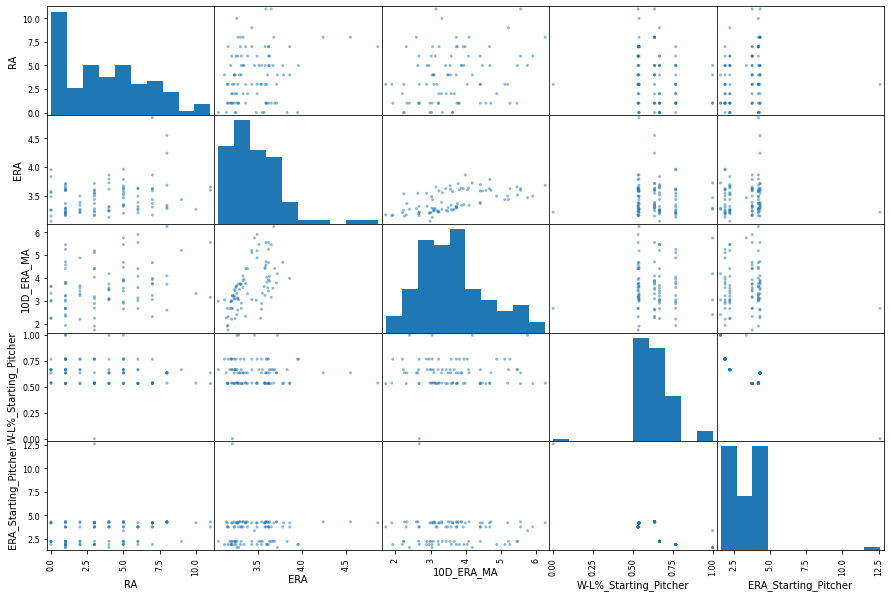

In [16]:
from pandas.plotting import scatter_matrix

attributes = [ 'RA', 'ERA', '10D_ERA_MA', 'W-L%_Starting_Pitcher', 'ERA_Starting_Pitcher']
scatter_matrix(finalDF['CHW'][attributes], figsize = (15, 10));

## Combine All Teams' Data For Training

In [17]:
MLB_Data = pd.DataFrame()

for team in teams:
    MLB_Data = MLB_Data.append(finalDF[team])

In [18]:
MLB_Data['W/L'] = MLB_Data['W/L'].map({'W' : 'W',
                                       'L' : 'L',
                                       'L-wo' : 'L',
                                       'W-wo' : 'W'})

In [19]:
MLB_Data['W/L'].value_counts()

L    1417
W    1417
Name: W/L, dtype: int64

In [20]:
#MLB_Data.to_csv('TrainData.csv')
print(len(MLB_Data))

2834


# Machine Learning

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


train_set, test_set = train_test_split(MLB_Data, test_size = 0.2, random_state = 42)

# Read in data that covers multiple years   <- USE FOR COMBINED YEAR DATA
#MLBCombinedYearData = pd.read_csv('CombinedYearsData.csv')
#train_set, test_set = train_test_split(MLBCombinedYearData, test_size = 0.15, random_state = 42)


In [22]:
''' Break down the features by home and away teams and we separate pitching features since these are assembled in a different manner. 
    Pitching stats are not taken from the last game (since a different pitcher pitched), but rather taken from pitching table'''

home_features = ['BA', '10D_BA_MA', '10D_SLG_MA', '10D_ERA_MA', '10D_WHIP_MA', 'cLI', '10D_SO_MA_batting', '10D_SO_MA_pitching',
                 '15D_RBI_MA', '7D_HR_MA', '10D_BB_MA', 'ERA', '5D_Pit/In_MA', 'Run_Margin_10D_Exp_MA',
                'Bullpen_ERA', 'Bullpen_WHIP', 'Bullpen_H9', 'Bullpen_HR9', 'Bullpen_BB9', 'Bullpen_SO9', 'Bullpen_SO/W', 'Bullpen_FIP',
                    'Bullpen_ERA+', 'Closer_ERA', 'Closer_WHIP', 'Closer_H9', 'Closer_HR9', 'Closer_BB9', 'Closer_SO9', 'Closer_SO/W', 'Closer_FIP', 'Closer_ERA+',
                 'SB_Avg', 'CS_Avg', 'SO_Pct_8MA_batting', 'Pit/In_Avg', '5D_Pit/In_MA', 'Str/Pit_Ratio_Avg', 'Str/Pit_Ratio_10D_MA', 'BB/BF_Ratio_Avg',
                 'BB/BF_Ratio_10D_MA', 'Team_Avg_Fld%','Team_Avg_Fld%', 'Team_Avg_Rdrs/yr', 'Team_Avg_Rtot/yr', 'Team_Avg_RF/G', '18D_R_MA', '18D_RA_MA']

home_pitching_features = ['W-L%_Starting_Pitcher', 'WHIP_Starting_Pitcher', 'SO/W_Starting_Pitcher', 'SO9_Starting_Pitcher', 'ERA_Starting_Pitcher',
                 'W_Starting_Pitcher', 'L_Starting_Pitcher', 'H9_Starting_Pitcher', 'HR9_Starting_Pitcher', 'BB9_Starting_Pitcher', 'FIP_Starting_Pitcher',
                 'ERA+_Starting_Pitcher', 'Walk_Pct_Starting_Pitcher', 'SO_Pct_Starting_Pitcher']

opponent_features = ['10D_BA_MA_Opponent', '10D_SLG_MA_Opponent', '10D_ERA_MA_Opponent', '10D_WHIP_MA_Opponent', 'BA_Opponent', 'cLI_Opponent',
                     '10D_SO_MA_batting_Opponent', '10D_SO_MA_pitching_Opponent', '15D_RBI_MA_Opponent', '7D_HR_MA_Opponent', '10D_BB_MA_Opponent',
                     'ERA_Opponent', '5D_Pit/In_MA_Opponent', 'Run_Margin_10D_Exp_MA_Opponent', 'Bullpen_ERA_Opponent', 'Bullpen_WHIP_Opponent', 'Bullpen_H9_Opponent',
                     'Bullpen_HR9_Opponent', 'Bullpen_BB9_Opponent', 'Bullpen_SO9_Opponent', 'Bullpen_SO/W_Opponent', 'Bullpen_FIP_Opponent',
                    'Bullpen_ERA+_Opponent', 'Closer_ERA_Opponent', 'Closer_WHIP_Opponent', 'Closer_H9_Opponent', 'Closer_HR9_Opponent',
                     'Closer_BB9_Opponent', 'Closer_SO9_Opponent', 'Closer_SO/W_Opponent', 'Closer_FIP_Opponent', 'Closer_ERA+_Opponent', 'SB_Avg_Opponent',
                     'CS_Avg_Opponent', 'SO_Pct_8MA_batting_Opponent', 'Pit/In_Avg_Opponent', '5D_Pit/In_MA_Opponent', 'Str/Pit_Ratio_Avg_Opponent',
                     'Str/Pit_Ratio_10D_MA_Opponent', 'BB/BF_Ratio_Avg_Opponent', 'BB/BF_Ratio_10D_MA_Opponent', 'Team_Avg_Fld%_Opponent','Team_Avg_Fld%_Opponent',
                     'Team_Avg_Rdrs/yr_Opponent', 'Team_Avg_Rtot/yr_Opponent', 'Team_Avg_RF/G_Opponent', '18D_R_MA_Opponent', '18D_RA_MA_Opponent'] 

opponent_pitching_features = [ 'W-L%_Starting_Pitcher_Opponent', 'WHIP_Starting_Pitcher_Opponent', 'SO/W_Starting_Pitcher_Opponent', 'SO9_Starting_Pitcher_Opponent', 'ERA_Starting_Pitcher_Opponent',
                               'W_Starting_Pitcher_Opponent', 'L_Starting_Pitcher_Opponent', 'H9_Starting_Pitcher_Opponent', 'HR9_Starting_Pitcher_Opponent', 'BB9_Starting_Pitcher_Opponent',
                               'FIP_Starting_Pitcher_Opponent', 'ERA+_Starting_Pitcher_Opponent', 'Walk_Pct_Starting_Pitcher', 'SO_Pct_Starting_Pitcher_Opponent'] 


all_features = home_features + home_pitching_features + opponent_features + opponent_pitching_features


## Create Pipeline for Standardizing Data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

# fit transformation to training data and then transform TestData
X_train = num_pipeline.fit_transform(train_set[all_features])
X_test = num_pipeline.transform(test_set[all_features])

# Define the Model type
#forest_reg = RandomForestRegressor()
#DT= DecisionTreeClassifier()
model = svm.SVC(probability = True)

# prepare data and labels
y_train = train_set['W/L']
y_test = test_set['W/L']


# fit model to data
model.fit(X_train, y_train)

# calculate confidence in predictions
class_probabilities = model.predict_proba(X_test)

# determine Classification
pred= model.predict(X_test)

print(class_probabilities)

[[0.5621253  0.4378747 ]
 [0.33457664 0.66542336]
 [0.82554687 0.17445313]
 ...
 [0.49187188 0.50812812]
 [0.61309697 0.38690303]
 [0.34247565 0.65752435]]


In [23]:
len(MLB_Data[all_features].columns)

124

In [24]:
test_set['W/L']

5     W
1     W
2     W
11    W
5     L
     ..
1     W
6     W
4     W
2     W
3     W
Name: W/L, Length: 567, dtype: object

In [25]:
pred

array(['L', 'W', 'L', 'W', 'L', 'L', 'W', 'W', 'L', 'L', 'L', 'W', 'W',
       'L', 'L', 'W', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W',
       'L', 'L', 'W', 'L', 'L', 'L', 'L', 'W', 'L', 'W', 'W', 'L', 'W',
       'L', 'L', 'W', 'L', 'L', 'L', 'W', 'W', 'L', 'W', 'W', 'L', 'W',
       'W', 'W', 'L', 'W', 'L', 'W', 'W', 'W', 'L', 'W', 'L', 'W', 'L',
       'W', 'W', 'L', 'L', 'L', 'W', 'L', 'L', 'W', 'W', 'W', 'W', 'W',
       'L', 'W', 'L', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'L', 'L', 'L',
       'L', 'W', 'W', 'L', 'W', 'L', 'W', 'L', 'W', 'L', 'W', 'L', 'L',
       'W', 'L', 'W', 'W', 'W', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'W', 'W', 'L', 'W', 'L', 'L', 'W', 'W', 'W', 'L',
       'W', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'W', 'W', 'L', 'L', 'L',
       'L', 'W', 'L', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'W', 'L', 'L',
       'L', 'W', 'W', 'W', 'W', 'L', 'L', 'W', 'L', 'L', 'W', 'W', 'L',
       'W', 'L', 'W', 'W', 'L', 'W', 'W', 'L', 'W', 'W', 'W', 'L

In [26]:
# yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score

# accuracy for SVC
print('SVC Accuracy Score: ', accuracy_score(test_set['W/L'], pred))


SVC Accuracy Score:  0.6684303350970018


C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Danel\anaconda3\env

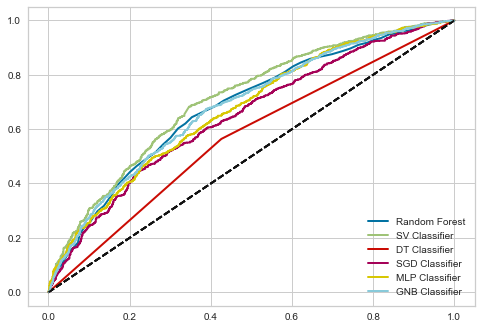

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal
    [...] # grid and axis labels
    
    
# fit transformation to training data and then transform TestData
X_train = num_pipeline.fit_transform(train_set[all_features])
X_test = num_pipeline.transform(test_set[all_features])

# Define the Model type
#forest_reg = RandomForestRegressor()
#DT= DecisionTreeClassifier()
model = svm.SVC(probability = True)

# prepare data and labels
y_train = train_set['W/L']
y_test = test_set['W/L']

# map "W" and "L" to numerical values
y_train = y_train.map({'W':1,
                       'L':0})

# Random Forest Classifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv = 5, method = 'predict_proba')
y_scores_forest = y_probas_forest[:, 1]  # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

# SV Classifer
SV_clf = svm.SVC(probability = True, random_state = 42)
y_probas_SV = cross_val_predict(SV_clf, X_train, y_train, cv = 5, method = 'predict_proba')
y_scores_SV = y_probas_SV[:, 1]  # score = probability of positive class
fpr_SV, tpr_SV, thresholds_SV = roc_curve(y_train, y_scores_SV)

# Decison-Tree Classifer
DT_clf = DecisionTreeClassifier(random_state = 42)
y_probas_DT = cross_val_predict(DT_clf, X_train, y_train, cv = 5, method = 'predict_proba')
y_scores_DT = y_probas_DT[:, 1]  # score = probability of positive class
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_train, y_scores_DT)

# Stochastic Gradient Descent Classifer
# Decison-Tree Classifer
SGD_clf = SGDClassifier(loss='log', random_state = 42)
y_probas_SGD = cross_val_predict(SGD_clf, X_train, y_train, cv = 5, method = 'predict_proba')
y_scores_SGD = y_probas_SGD[:, 1]  # score = probability of positive class
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_train, y_scores_SGD)

# Multi-Layered Perceptron Algorithm
MLP_clf = MLPClassifier(random_state = 42)
y_probas_MLP = cross_val_predict(MLP_clf, X_train, y_train, cv = 5, method = 'predict_proba')
y_scores_MLP = y_probas_MLP[:, 1]  # score = probability of positive class
fpr_MLP, tpr_MLP, thresholds_MLP = roc_curve(y_train, y_scores_MLP)

# Multi-Layered Perceptron Algorithm
GNB_clf = GaussianNB()
y_probas_GNB = cross_val_predict(GNB_clf, X_train, y_train, cv = 5, method = 'predict_proba')
y_scores_GNB = y_probas_GNB[:, 1]  # score = probability of positive class
fpr_GNB, tpr_GNB, thresholds_GNB= roc_curve(y_train, y_scores_GNB)

# Plot various ML techniques
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plot_roc_curve(fpr_SV, tpr_SV, 'SV Classifier')
plot_roc_curve(fpr_DT, tpr_DT, 'DT Classifier')
plot_roc_curve(fpr_SGD, tpr_SGD, 'SGD Classifier')
#plot_roc_curve(fpr_nca, tpr_nca, 'NCA Classifier')
#plot_roc_curve(fpr_MLP, tpr_MLP, 'MLP Classifier')
plot_roc_curve(fpr_MLP, tpr_MLP, 'MLP Classifier')
plot_roc_curve(fpr_GNB, tpr_GNB, 'GNB Classifier')
plt.legend(loc = 'lower right')
plt.show()

## PCA Analysis

Neighborhood Components Analysis (NCA) Accuracy Score:  0.6331569664902998


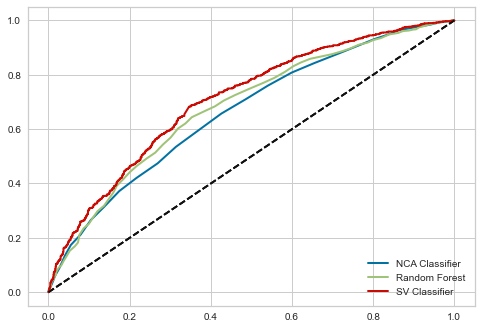

In [28]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline

# fit transformation to training data and then transform TestData
X_train = num_pipeline.fit_transform(train_set[all_features])
X_test = num_pipeline.transform(test_set[all_features])

# prepare data and labels
y_train = train_set['W/L']
y_test = test_set['W/L']

# map "W" and "L" to numerical values
y_train = y_train.map({'W':1, 'L':0})
y_test = y_test.map({'W':1, 'L':0})

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=47)  # need to choose best k
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
#Pipeline(...)
print('Neighborhood Components Analysis (NCA) Accuracy Score: ', nca_pipe.score(X_test, y_test))

# Decison-Tree Classifer
nca_clf = nca_pipe
y_probas_nca = cross_val_predict(nca_clf, X_train, y_train, cv = 3, method = 'predict_proba')
y_scores_nca = y_probas_nca[:, 1]  # score = probability of positive class
fpr_nca, tpr_nca, thresholds_nca = roc_curve(y_train, y_scores_nca)

# comparing the most promising methods
plot_roc_curve(fpr_nca, tpr_nca, 'NCA Classifier')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plot_roc_curve(fpr_SV, tpr_SV, 'SV Classifier')
plt.legend(loc = 'lower right')
plt.show()

In [29]:
print('Neighborhood Components Analysis (NCA) Accuracy Score: ', nca_pipe.score(X_test, y_test))

GNB_clf.fit(X_train, y_train)
print('Gaussian Naive Bayes (GNB) Accuracy Score: ', GNB_clf.score(X_test, y_test))

MLP_clf.fit(X_train, y_train)
print('Multi-layer Perceptron (MLP) Accuracy Score: ', MLP_clf.score(X_test, y_test))

SGD_clf.fit(X_train, y_train)
print('Stochastic Gradient Descent (SGD) Accuracy Score: ', SGD_clf.score(X_test, y_test))

SV_clf.fit(X_train, y_train)
print('Support Vector Machines (SVM) Accuracy Score: ', SV_clf.score(X_test, y_test))

forest_clf.fit(X_train, y_train)
print('Random Forrest Classification Accuracy Score: ', forest_clf.score(X_test, y_test))



Neighborhood Components Analysis (NCA) Accuracy Score:  0.6331569664902998
Gaussian Naive Bayes (GNB) Accuracy Score:  0.6137566137566137


C:\Users\Danel\anaconda3\envs\quant\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi-layer Perceptron (MLP) Accuracy Score:  0.6384479717813051
Stochastic Gradient Descent (SGD) Accuracy Score:  0.6172839506172839
Support Vector Machines (SVM) Accuracy Score:  0.6684303350970018
Random Forrest Classification Accuracy Score:  0.6384479717813051


## Getting Todays Games' Data

### Web Scraping Todays Games

In [31]:
import urllib.request 
from bs4 import BeautifulSoup
import re


# WEB SCRAPING TODAYS GAMES
todays_games_url = 'https://www.baseball-reference.com/leagues/MLB-schedule.shtml#today'
team_list = ['Arizona D\'Backs', 'Atlanta Braves', 'Baltimore Orioles', 'Boston Red Sox', 'Chicago White Sox', 'Chicago Cubs',
             'Cincinnati Reds', 'Cleveland Indians', 'Colorado Rockies', 'Detroit Tigers', 'Houston Astros', 'Kansas City Royals',
             'Los Angeles Angels', 'Los Angeles Dodgers', 'Miami Marlins', 'Milwaukee Brewers', 'Minnesota Twins', 'New York Yankees',
             'New York Mets', 'Oakland Athletics', 'Philadelphia Phillies','Pittsburgh Pirates', 'San Diego Padres', 'San Francisco Giants', 
             'Seattle Mariners', 'St. Louis Cardinals', 'Tampa Bay Rays', 'Texas Rangers', 'Toronto Blue Jays', 'Washington Nationals']


# opening the url for reading
html = urllib.request.urlopen(todays_games_url)

# parsing the html file
soup = BeautifulSoup(html, 'html.parser')

todays_games_DF = pd.DataFrame(columns = ['Away Team', 'Home Team'])

target = soup.find('h3', text = 'Today\'s Games')
#target = soup.find('h3', text = 'Monday, July 26, 2021')
for sib in target.find_next_siblings(['p']):
    if sib.name=="h3":
        break
    else:
        #todays_games_DF = todays_games_DF.append(sib.text)
        matchup = re.findall(r"(?=("+'|'.join(team_list)+r"))", sib.text)
        print(matchup)
        matchup_series = pd.Series(matchup, index = todays_games_DF.columns)
        todays_games_DF = todays_games_DF.append(matchup_series, ignore_index = True)

# for para in htmlParse.find_all("p"):
#     print(para.get_text())

#df = pd.read_html(todays_games_url)

# for index, team in enumerate(teams):
#     ## Collect schedule information for each team
#     baseball_schedule_url = 'https://www.baseball-reference.com/teams/' + team + '/2021-schedule-scores.shtml'
#     dfs = pd.read_html(baseball_schedule_url)
#     scheduleDF = pd.concat(dfs)

['Miami Marlins', 'Baltimore Orioles']
['Washington Nationals', 'Philadelphia Phillies']
['Milwaukee Brewers', 'Pittsburgh Pirates']
['Toronto Blue Jays', 'Boston Red Sox']
['St. Louis Cardinals', 'Cleveland Indians']
['Atlanta Braves', 'New York Mets']
['New York Yankees', 'Tampa Bay Rays']
['Cincinnati Reds', 'Chicago Cubs']
["Arizona D'Backs", 'Texas Rangers']
['Chicago White Sox', 'Kansas City Royals']
['Detroit Tigers', 'Minnesota Twins']
['Colorado Rockies', 'Los Angeles Angels']
['Los Angeles Dodgers', 'San Francisco Giants']
['Oakland Athletics', 'San Diego Padres']
['Houston Astros', 'Seattle Mariners']


In [32]:
abreviation_map = {'Arizona D\'Backs' : 'ARI', 'Atlanta Braves': 'ATL', 'Baltimore Orioles': 'BAL', 'Boston Red Sox': 'BOS', 'Chicago White Sox': 'CHW', 'Chicago Cubs': 'CHC',
             'Cincinnati Reds': 'CIN', 'Cleveland Indians': 'CLE', 'Colorado Rockies': 'COL', 'Detroit Tigers': 'DET', 'Houston Astros': 'HOU', 'Kansas City Royals': 'KCR',
             'Los Angeles Angels': 'LAA', 'Los Angeles Dodgers':'LAD', 'Miami Marlins': 'MIA', 'Milwaukee Brewers': 'MIL', 'Minnesota Twins': 'MIN', 'New York Yankees': 'NYY',
             'New York Mets': 'NYM', 'Oakland Athletics': 'OAK', 'Philadelphia Phillies': 'PHI','Pittsburgh Pirates': 'PIT', 'San Diego Padres': 'SDP', 'San Francisco Giants': 'SFG', 
             'Seattle Mariners': 'SEA', 'St. Louis Cardinals': 'STL', 'Tampa Bay Rays': 'TBR', 'Texas Rangers': 'TEX', 'Toronto Blue Jays': 'TOR', 'Washington Nationals': 'WSN'}

# Replace full names with abreviations
todays_games_DF.replace(abreviation_map, inplace = True)


### Web Scraping Today's Pitchers' Stats

In [33]:
todays_pitcher_DF = pd.DataFrame()
todays_pitchers_url = 'https://www.baseball-reference.com/previews/'
probable_starting_pitchers = pd.read_html(todays_pitchers_url)

for index, table in enumerate(probable_starting_pitchers):
    if index % 2 == 0:
        todays_pitcher_DF = todays_pitcher_DF.append(table, ignore_index = True)
        continue
    else:
        todays_pitcher_DF = todays_pitcher_DF.append(table, ignore_index = True)

      
todays_pitcher_DF.rename(columns = {0: 'Team', 1: 'Starting Pitcher'}, inplace = True) # rename dataframe columns

todays_pitcher_DF.drop(2, axis = 1, inplace = True)
todays_pitcher_DF.dropna(thresh = 2, inplace=True, how = 'any') 
todays_pitcher_DF.reset_index(inplace = True)

todays_pitcher_DF['Pitcher Name'] = todays_pitcher_DF['Starting Pitcher'].str.replace(r'RHP|LHP|-man|[^a-zA-Z ]|day IL', '')
todays_pitcher_DF['Last Name'] = todays_pitcher_DF['Pitcher Name'].astype(str).str.split().str[1]
todays_pitcher_DF['First Name'] = todays_pitcher_DF['Pitcher Name'].astype(str).str.split().str[0]


todays_pitcher_DF.head(40)

<ipython-input-33-d2c62f1da7c3>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  todays_pitcher_DF['Pitcher Name'] = todays_pitcher_DF['Starting Pitcher'].str.replace(r'RHP|LHP|-man|[^a-zA-Z ]|day IL', '')


,index,Team,Starting Pitcher,Pitcher Name,Last Name,First Name
0,2,MIA,"Sandy Alcantara(#22, 25, RHP, 5-9, 3.23)",Sandy Alcantara,Alcantara,Sandy
1,3,BAL,"Spenser Watkins(#80, 28, RHP, 2-0, 1.65)",Spenser Watkins,Watkins,Spenser
2,6,WSN,"Erick Fedde(#23, 28, RHP, 4-7, 4.88)",Erick Fedde,Fedde,Erick
3,7,PHI,"Matt Moore(#31, 32, LHP, 0-2, 5.79)",Matt Moore,Moore,Matt
4,10,MIL,"Brett Anderson(#25, 33, LHP, 2-5, 4.26)",Brett Anderson,Anderson,Brett
5,11,PIT,"Tyler Anderson(#31, 31, LHP, 5-8, 4.35)",Tyler Anderson,Anderson,Tyler
6,14,TOR,"Robbie Ray(#38, 29, LHP, 8-5, 3.12)",Robbie Ray,Ray,Robbie
7,15,BOS,"Garrett Richards(#43, 33, RHP, 6-5, 4.99)",Garrett Richards,Richards,Garrett
8,18,STL,"Adam Wainwright(#50, 39, RHP, 7-6, 3.56)",Adam Wainwright,Wainwright,Adam
9,19,CLE,"Cal Quantrill(#47, 26, RHP, 2-2, 3.84)",Cal Quantrill,Quantrill,Cal


## Linking Todays Matchup Data With Todays Starting Pitcher Stats

In [34]:
matchupData = pd.DataFrame()

# Add data for each matchup
for index, team in todays_games_DF.iterrows():
    home_team = team['Home Team']
    away_team = team['Away Team']
    
    # Get home-team's data from team dataframe
    home_data = finalDF[home_team].sort_values(by = 'Gm#').tail(1)[home_features]
    home_data['Home Team'] = home_team
    
    # try to get todays pitcher data from rotation DF - if the todays pitcher is not known yet, take an average of 6 best pitchers in rotation
    try:
        home_pitcher_first_name = todays_pitcher_DF.loc[todays_pitcher_DF['Team'] == home_team,'First Name'].values[0] # get starting pitcher for home team
        home_pitcher_last_name = todays_pitcher_DF.loc[todays_pitcher_DF['Team'] == home_team,'Last Name'].values[0]   # extract first and last name since there are extra spaces in 'Pitcher Name' column
        #home_pitcher_name = home_pitcher_first_name + ' ' + home_pitcher_last_name                                     # combine first and last to fix spacing issue
        home_pitcher_data = pitching_rotation[home_team].loc[(pitching_rotation[home_team]['Pitcher First Name'] == home_pitcher_first_name) & (pitching_rotation[home_team]['Pitcher Last Name'] == home_pitcher_last_name)][home_pitching_features] # only include features that were used in training
    except:
        home_pitcher_data = pitching_rotation[home_team].loc[0:7][home_pitching_features].mean().to_frame().T # create dataframe with mean values of top 6 pitchers
    
    combined_home_data = pd.concat([home_data, home_pitcher_data], axis = 1)
    
    # reset index to zero since we want both of these dataframes to be in the same row when after we concatonate
    home_data.reset_index(drop=True, inplace=True)
    home_pitcher_data.reset_index(drop=True, inplace=True)
    
    combined_home_data = pd.concat([home_data, home_pitcher_data], axis = 1)
    
    away_data = finalDF[home_team].sort_values(by = 'Gm#').tail(1)[opponent_features]
    away_data['Away Team'] = away_team
    
        # Do the same for away-team pitchers
    try:
        away_pitcher_first_name = todays_pitcher_DF.loc[todays_pitcher_DF['Team'] == away_team,'First Name'].values[0] # get starting pitcher for away team
        away_pitcher_last_name = todays_pitcher_DF.loc[todays_pitcher_DF['Team'] == away_team,'Last Name'].values[0]   # extract first and last name since there are extra spaces in 'Pitcher Name' column
        #away_pitcher_name = away_pitcher_first_name + ' ' + away_pitcher_last_name                                     # combine first and last to fix spacing issue
        away_pitcher_data = pitching_rotation[away_team].loc[(pitching_rotation[away_team]['Pitcher First Name'] == away_pitcher_first_name) & (pitching_rotation[away_team]['Pitcher Last Name'] == away_pitcher_last_name)][home_pitching_features] # only include features that were used in training
    except:
        away_pitcher_data = pitching_rotation[away_team].loc[0:7][home_pitching_features].mean().to_frame().T # create dataframe with mean values of top 6 pitchers
    
    away_pitcher_data = away_pitcher_data.add_suffix('_Opponent')  # add suffix so we know stats are for opposing team
    
    # reset index so that we can concatanate on this row
    away_data.reset_index(drop=True, inplace=True)
    away_pitcher_data.reset_index(drop=True, inplace=True)


    combined_away_data = pd.concat([away_data, away_pitcher_data], axis = 1)
    
    #print(combined_home_data)
    
    matchupData = matchupData.append(pd.concat([combined_home_data, combined_away_data], axis = 1))
    
matchupData = matchupData.loc[:,~matchupData.columns.duplicated()] # Delete Duplicate Columns - NOTE: for some reason columns that are added 
# using latest methods are duplicated in the matchup data (the stats may be contained in the pitcher dataframe?)
# Columns include: ['5D_Pit/In_MA', '5D_Pit/In_MA_Opponent', etc.]


## Predicting Todays Matchups

### Fit Model to Data

In [35]:
# fit transformation to training data and then transform TestData
#X_train = num_pipeline.fit_transform(MLB_Data[all_features])
X_train = num_pipeline.fit_transform(train_set[all_features])
# fit transformation to training data and then transform TestData



# Define the Model type
#forest_reg = RandomForestRegressor()
#DT= DecisionTreeClassifier()
#model = SGDClassifier(loss='log', random_state = 42)
model =  svm.SVC(probability = True, random_state = 42)

# prepare data and labels
y_train = train_set['W/L']


# fit model to data
model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [36]:
matchupData[['Team_Avg_Fld%','Team_Avg_Fld%', 'Team_Avg_Rdrs/yr', 'Team_Avg_Rtot/yr', 'Team_Avg_RF/G', 'Team_Avg_RF/G_Opponent']]

,Team_Avg_Fld%,Team_Avg_Fld%,Team_Avg_Rdrs/yr,Team_Avg_Rtot/yr,Team_Avg_RF/G,Team_Avg_RF/G_Opponent
0,0.982583,0.982583,-1.750000,-3.916667,3.012500,3.707273
0,0.979667,0.979667,-9.583333,-6.250000,3.716667,3.707273
0,0.983462,0.983462,0.692308,-2.000000,3.763846,3.557333
0,0.977500,0.977500,1.800000,-4.400000,3.638000,3.506667
0,0.985917,0.985917,-2.083333,2.000000,3.630833,3.590714
0,0.983750,0.983750,4.833333,3.000000,3.577500,3.264545
0,0.985357,0.985357,7.285714,4.785714,3.590714,3.630833
0,0.983231,0.983231,2.230769,2.538462,3.125385,3.720833
0,0.984273,0.984273,5.000000,10.090909,3.885455,3.849167
0,0.977273,0.977273,-3.272727,-4.636364,3.060909,3.478333


### Fit New Data

In [37]:
# transform the matchup data
newData = num_pipeline.transform(matchupData[all_features])


# determine Classification
pred = model.predict(newData)

# calculate confidence in predictions
class_probabilities = model.predict_proba(newData)

matchupData['Predictions'] = pred.tolist()

#matchupData[['Home Team Win Probability', 'Away Team Win Probability']] = class_probabilities.tolist()
matchupData[['Away Team Win Probability','Home Team Win Probability',]] = class_probabilities.tolist()

print(class_probabilities)

[[0.18085796 0.81914204]
 [0.5        0.5       ]
 [0.58913311 0.41086689]
 [0.53475639 0.46524361]
 [0.64945669 0.35054331]
 [0.55422584 0.44577416]
 [0.35652205 0.64347795]
 [0.47292214 0.52707786]
 [0.81514171 0.18485829]
 [0.47903756 0.52096244]
 [0.38258851 0.61741149]
 [0.34802025 0.65197975]
 [0.62721509 0.37278491]
 [0.53389629 0.46610371]
 [0.56321344 0.43678656]]


In [38]:
matchupData[['Home Team', 'Away Team', 'Home Team Win Probability', 'Away Team Win Probability', 'Predictions']].sort_values(by = 'Home Team Win Probability', ascending = False)

,Home Team,Away Team,Home Team Win Probability,Away Team Win Probability,Predictions
0,BAL,MIA,0.819142,0.180858,W
0,LAA,COL,0.651980,0.348020,W
0,TBR,NYY,0.643478,0.356522,W
0,MIN,DET,0.617411,0.382589,W
0,CHC,CIN,0.527078,0.472922,W
0,KCR,CHW,0.520962,0.479038,W
0,PHI,WSN,0.500000,0.500000,W
0,SDP,OAK,0.466104,0.533896,L
0,BOS,TOR,0.465244,0.534756,L
0,NYM,ATL,0.445774,0.554226,L


## Home and Away Runs Prediction

In [39]:
from sklearn.linear_model import Ridge
# Define 4 different types of features to be used (away and home stats seperated/ pitching and non-pitching stats sepearated)

# home_features = ['BA', '10D_BA_MA', '10D_SLG_MA', '10D_ERA_MA', '10D_WHIP_MA', 'cLI', '10D_SO_MA_batting', '10D_SO_MA_pitching',
#                  '15D_RBI_MA', '7D_HR_MA', '10D_BB_MA', 'ERA', '7D_Pit/In_MA']

# home_pitching_features = ['W-L%_Starting_Pitcher', 'WHIP_Starting_Pitcher', 'SO/W_Starting_Pitcher', 'SO9_Starting_Pitcher', 'ERA_Starting_Pitcher',
#                  'W_Starting_Pitcher', 'HR_Starting_Pitcher', 'FIP_Starting_Pitcher']

# opponent_features = ['10D_BA_MA_Opponent', '10D_SLG_MA_Opponent', '10D_ERA_MA_Opponent', '10D_WHIP_MA_Opponent', 'BA_Opponent', 'cLI_Opponent',
#                      '10D_SO_MA_batting_Opponent', '10D_SO_MA_pitching_Opponent', '15D_RBI_MA_Opponent', '7D_HR_MA_Opponent', '10D_BB_MA_Opponent',
#                      'ERA_Opponent', '7D_Pit/In_MA_Opponent'] 

# opponent_pitching_features = [ 'W-L%_Starting_Pitcher_Opponent', 'WHIP_Starting_Pitcher_Opponent', 'SO/W_Starting_Pitcher_Opponent', 'SO9_Starting_Pitcher_Opponent', 'ERA_Starting_Pitcher_Opponent',
#                      'W_Starting_Pitcher_Opponent', 'HR_Starting_Pitcher_Opponent', 'FIP_Starting_Pitcher_Opponent'] 


all_features = home_features + home_pitching_features + opponent_features + opponent_pitching_features


## Create Pipeline for Standardizing Data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

# fit transformation to training data and then transform TestData
#TrainingData = num_pipeline.fit_transform(MLB_Data[all_features])
TrainingData = num_pipeline.fit_transform(MLB_Data[all_features])
TestData = num_pipeline.transform(test_set[all_features])

# Define the Model type
#forest_reg = RandomForestRegressor()
#DT= DecisionTreeClassifier()
#model = RandomForestRegressor()
model = Ridge(alpha = 0.1)

# prepare data and labels
runs_scored_labels = MLB_Data['R']
runs_against_labels = MLB_Data['RA']


# fit model to data
model.fit(TrainingData, runs_scored_labels)

# calculate confidence in predictions
#class_probabilities = model.predict_proba(TestData)

# determine Classification
runs_pred = model.predict(newData)


model.fit(TrainingData, runs_against_labels)
runs_against_pred = model.predict(newData)

matchupData['Predicted Home-Team Runs'] = runs_pred.tolist()
matchupData['Predicted Away-Team Runs'] = runs_against_pred.tolist()

In [40]:
matchupData[['Home Team', 'Away Team', 'Home Team Win Probability', 'Away Team Win Probability', 'Predictions', 'Predicted Home-Team Runs', 'Predicted Away-Team Runs']].sort_values(by = 'Home Team Win Probability', ascending = False)

,Home Team,Away Team,Home Team Win Probability,Away Team Win Probability,Predictions,Predicted Home-Team Runs,Predicted Away-Team Runs
0,BAL,MIA,0.819142,0.180858,W,5.099812,3.104768
0,LAA,COL,0.651980,0.348020,W,3.713983,3.661695
0,TBR,NYY,0.643478,0.356522,W,4.380962,3.078112
0,MIN,DET,0.617411,0.382589,W,3.456219,5.023133
0,CHC,CIN,0.527078,0.472922,W,7.154337,5.001453
0,KCR,CHW,0.520962,0.479038,W,4.908093,1.689392
0,PHI,WSN,0.500000,0.500000,W,4.394668,6.740523
0,SDP,OAK,0.466104,0.533896,L,4.241688,4.267458
0,BOS,TOR,0.465244,0.534756,L,4.700912,4.806209
0,NYM,ATL,0.445774,0.554226,L,1.255777,5.396570


In [41]:
matchupData[matchupData['Home Team'] == 'TBR']['Pitcher Last Name']

KeyError: 'Pitcher Last Name'

In [ ]:
matchupData[matchupData['Home Team'] == 'CHC'][['BA','BA_Opponent','H9_Starting_Pitcher','HR9_Starting_Pitcher','BB9_Starting_Pitcher','FIP_Starting_Pitcher','ERA+_Starting_Pitcher' ,'Walk_Pct_Starting_Pitcher_Opponent', 'SO_Pct_Starting_Pitcher']]
      

In [ ]:
print(len(MLB_Data['W/L']))

In [ ]:
teamsData['CHC']

In [ ]:
import pandas as pd
df = pd.DataFrame({'X':[78,85,96,80,86], 'Y':[84,94,89,83,86],'Z':[86,97,96,72,83]});
print(df)

In [ ]:
df['A']= 3

## Predictions Using PCA

In [42]:
# fit transformation to training data and then transform TestData
X_train = num_pipeline.fit_transform(train_set[all_features])
#X_test = num_pipeline.transform(test_set[all_features])

# prepare data and labels
y_train = train_set['W/L']
#y_test = test_set['W/L']

# map "W" and "L" to numerical values
y_train = y_train.map({'W':1, 'L':0})
#y_test = y_test.map({'W':1, 'L':0})

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=47)  # need to choose best k
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)# fit model to data
#Pipeline(...)
#print('Neighborhood Components Analysis (NCA) Accuracy Score: ', nca_pipe.score(X_test, y_test))

# fit model to data
#model.fit(X_train, y_train)

# # calculate confidence in predictions
# class_probabilities = model.predict_proba(X_test)

# # determine Classification
# #pred= model.predict(X_test)

# print(class_probabilities)

Pipeline(steps=[('nca', NeighborhoodComponentsAnalysis(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=47))])

In [43]:
# transform the matchup data
newData = num_pipeline.transform(matchupData[all_features])


# determine Classification
pred = nca_pipe.predict(newData)

# calculate confidence in predictions
class_probabilities = nca_pipe.predict_proba(newData)

matchupData['Predictions'] = pred.tolist()

#matchupData[['Home Team Win Probability', 'Away Team Win Probability']] = class_probabilities.tolist()
matchupData[['Away Team Win Probability','Home Team Win Probability',]] = class_probabilities.tolist()

#matchupData.map({1:'W', 0:'L'})

print(class_probabilities)

[[0.29787234 0.70212766]
 [0.44680851 0.55319149]
 [0.61702128 0.38297872]
 [0.38297872 0.61702128]
 [0.5106383  0.4893617 ]
 [0.5106383  0.4893617 ]
 [0.34042553 0.65957447]
 [0.55319149 0.44680851]
 [0.72340426 0.27659574]
 [0.42553191 0.57446809]
 [0.55319149 0.44680851]
 [0.42553191 0.57446809]
 [0.4893617  0.5106383 ]
 [0.40425532 0.59574468]
 [0.55319149 0.44680851]]


In [44]:
matchupData[['Home Team', 'Away Team', 'Home Team Win Probability', 'Away Team Win Probability', 'Predictions']].sort_values(by = 'Home Team Win Probability', ascending = False)

,Home Team,Away Team,Home Team Win Probability,Away Team Win Probability,Predictions
0,BAL,MIA,0.702128,0.297872,1
0,TBR,NYY,0.659574,0.340426,1
0,BOS,TOR,0.617021,0.382979,1
0,SDP,OAK,0.595745,0.404255,1
0,KCR,CHW,0.574468,0.425532,1
0,LAA,COL,0.574468,0.425532,1
0,PHI,WSN,0.553191,0.446809,1
0,SFG,LAD,0.510638,0.489362,1
0,CLE,STL,0.489362,0.510638,0
0,NYM,ATL,0.489362,0.510638,0


In [ ]:
print(np.sqrt(len(train_set)))